In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

In [6]:
# Download NLTK data (only once)
nltk.download('stopwords')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
class SpamDetectorLSTM:
    def __init__(self, max_words=5000, max_len=50, embedding_dim=32):
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
        self.model = None
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Enhanced text cleaning with stemming and stopword removal"""
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
        text = re.sub(r'\d+', ' ', text)                      # Remove all numbers
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()              # Remove extra spaces

        # Apply stemming and remove stopwords
        words = text.split()
        words = [self.stemmer.stem(word) for word in words if word not in self.stop_words]
        return ' '.join(words)

    def load_data(self, filepath):
        """Load and preprocess dataset"""
        # Read CSV with comma separator and proper column names
        df = pd.read_csv(filepath, encoding='utf-8')

        # Handle different possible column name formats
        if 'label' in df.columns and 'text' in df.columns:
            pass  # Already has correct columns
        elif 'label_num' in df.columns and 'text' in df.columns:
            df = df.rename(columns={'label_num': 'label'})
        elif 'v1' in df.columns and 'v2' in df.columns:  # Common in spam datasets
            df = df.rename(columns={'v1': 'label', 'v2': 'text'})
        else:
            raise ValueError("CSV file must contain either 'label'/'text' or 'v1'/'v2' columns")

        # Convert labels to binary (0 for ham, 1 for spam)
        df['label'] = df['label'].map({'ham': 0, 'spam': 1})

        # Handle NaN values if any exist
        df = df.dropna(subset=['text'])

        # Preprocess the text
        df['cleaned_text'] = df['text'].apply(self.preprocess_text)

        return df['cleaned_text'].values, df['label'].values

    def prepare_data(self, texts, labels, test_size=0.1, val_size=0.1):
        """Split data into 80-10-10 train-val-test sets"""
        # First split: train (80%) vs temp (20%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=test_size + val_size, stratify=labels, random_state=42
        )

        # Second split: temp into val (10%) and test (10%)
        val_ratio = val_size / (test_size + val_size)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=1-val_ratio, stratify=y_temp, random_state=42
        )

        # Tokenize texts
        self.tokenizer.fit_on_texts(X_train)
        X_train_seq = self.tokenizer.texts_to_sequences(X_train)
        X_val_seq = self.tokenizer.texts_to_sequences(X_val)
        X_test_seq = self.tokenizer.texts_to_sequences(X_test)

        # Pad sequences
        X_train_pad = pad_sequences(X_train_seq, maxlen=self.max_len, padding='post', truncating='post')
        X_val_pad = pad_sequences(X_val_seq, maxlen=self.max_len, padding='post', truncating='post')
        X_test_pad = pad_sequences(X_test_seq, maxlen=self.max_len, padding='post', truncating='post')

        return X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test

    def build_model(self):
        """Improved model with stacked LSTM and metrics"""
        self.model = Sequential([
            Embedding(
                input_dim=self.max_words,
                output_dim=self.embedding_dim,
                input_length=self.max_len,
                mask_zero=True
            ),
            Dropout(0.3),
            Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
            Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=15, batch_size=32):
        """Train with early stopping and learning rate reduction"""
        class_weights = {0: 1.0, 1: 3.0}  # Higher weight for spam

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        return history

    def plot_training_history(self, history):
        """Plot training and validation accuracy/loss over epochs"""
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self, X_test, y_test):
        """Plot ROC curve with AUC score"""
        y_prob = self.model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_precision_recall_curve(self, X_test, y_test):
        """Plot precision-recall curve"""
        y_prob = self.model.predict(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='upper right')
        plt.show()

    def plot_class_distribution(self, y_train, y_val, y_test):
        """Plot class distribution across splits"""
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        splits = [('Train', y_train), ('Validation', y_val), ('Test', y_test)]
        for i, (name, data) in enumerate(splits):
            counts = pd.Series(data).value_counts()
            ax[i].pie(counts, labels=['Ham', 'Spam'], autopct='%1.1f%%',
                     colors=['lightgreen', 'lightcoral'])
            ax[i].set_title(f'{name} Set Distribution')

        plt.tight_layout()
        plt.show()

    def evaluate(self, X_test, y_test):
        """Enhanced evaluation with AUC-ROC and visualizations"""
        y_pred = (self.model.predict(X_test) > 0.5).astype(int)

        print("\n=== Classification Report ===")
        print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

        print("\n=== Confusion Matrix ===")
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC Curve
        self.plot_roc_curve(X_test, y_test)

        # Precision-Recall Curve
        self.plot_precision_recall_curve(X_test, y_test)

        # ROC-AUC Score
        y_prob = self.model.predict(X_test)
        auc = roc_auc_score(y_test, y_prob)
        print(f"\nAUC-ROC Score: {auc:.4f}")

    def predict(self, new_emails):
        """Predict spam/ham for new emails"""
        cleaned_emails = [self.preprocess_text(email) for email in new_emails]
        sequences = self.tokenizer.texts_to_sequences(cleaned_emails)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
        return (self.model.predict(padded) > 0.5).astype(int).flatten()

    def save_model(self, path='spam_detector.h5'):
        """Save the trained model"""
        self.model.save(path)
        print(f"Model saved to {path}")

    def load_model(self, path='spam_detector.h5'):
        """Load a pre-trained model"""
        self.model = tf.keras.models.load_model(path)
        print(f"Model loaded from {path}")


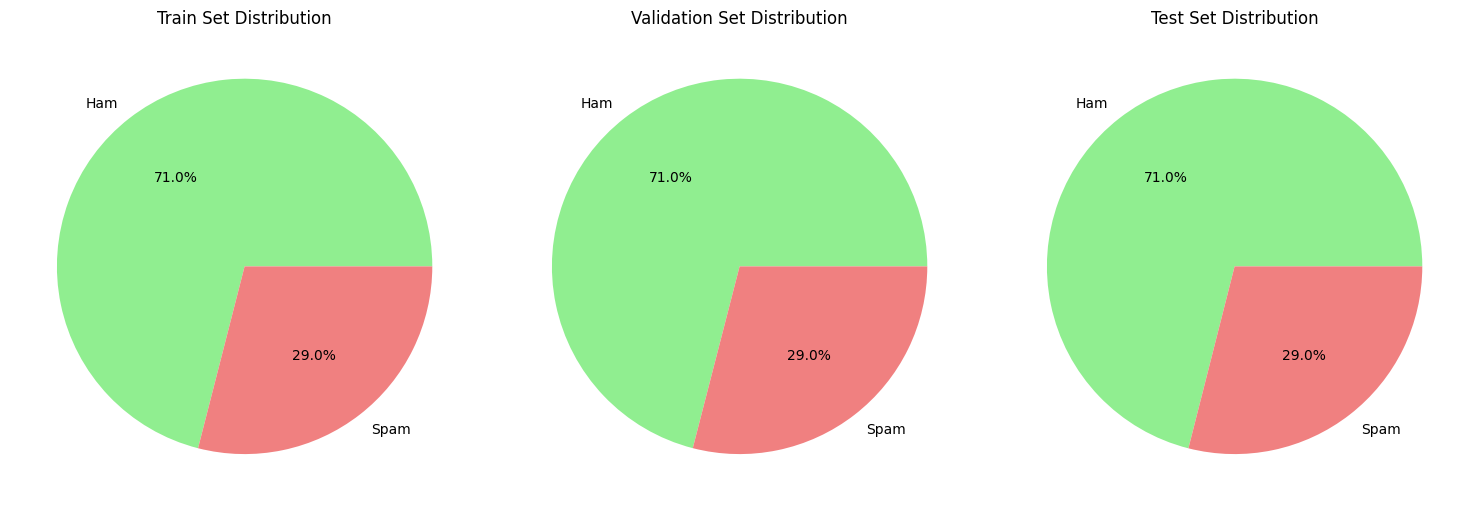

Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.6874 - loss: 2.8604 - precision_2: 0.5209 - recall_2: 0.9532 - val_accuracy: 0.9787 - val_loss: 0.3573 - val_precision_2: 0.9664 - val_recall_2: 0.9600 - learning_rate: 0.0010
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.9690 - loss: 0.3204 - precision_2: 0.9091 - recall_2: 0.9945 - val_accuracy: 0.9865 - val_loss: 0.1494 - val_precision_2: 0.9673 - val_recall_2: 0.9867 - learning_rate: 0.0010
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.9841 - loss: 0.1662 - precision_2: 0.9563 - recall_2: 0.9913 - val_accuracy: 0.9923 - val_loss: 0.1220 - val_precision_2: 0.9803 - val_recall_2: 0.9933 - learning_rate: 0.0010
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9896 - loss: 0.1088 - precision_2: 0.9682 - recall_2: 0.9975 - val_accuracy: 0.9923 - val_loss: 0.1032 - val_precision_2: 0.9803 - val_recall_2: 0.9933 - learning_rate: 0.0010
Ep

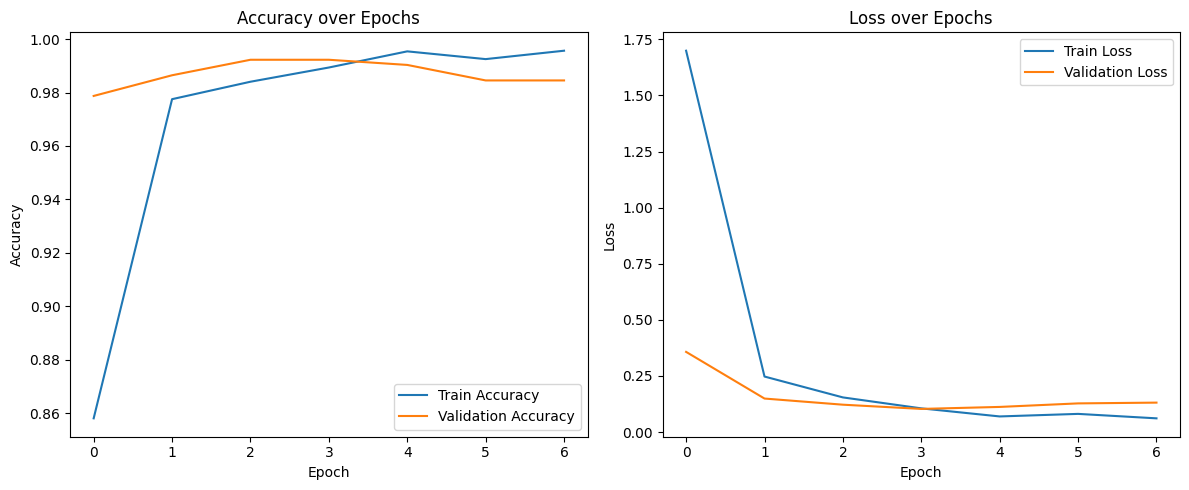

Evaluating model...
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       368
        spam       0.93      1.00      0.96       150

    accuracy                           0.98       518
   macro avg       0.96      0.98      0.97       518
weighted avg       0.98      0.98      0.98       518


=== Confusion Matrix ===


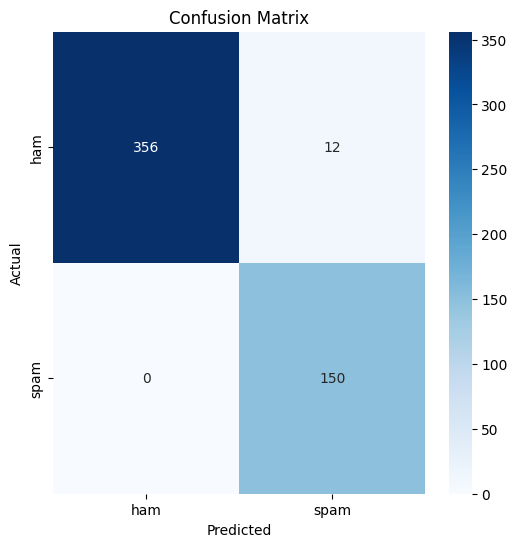

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


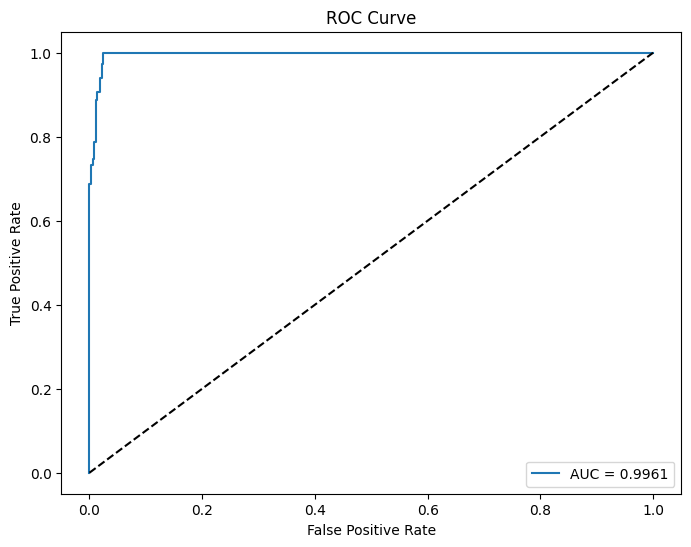

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


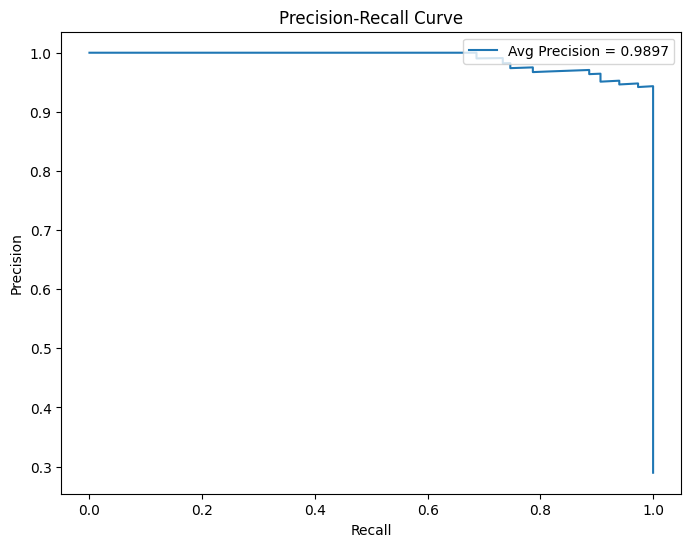

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

AUC-ROC Score: 0.9961


In [8]:
if __name__ == "__main__":
    # Initialize and train
    detector = SpamDetectorLSTM()
    texts, labels = detector.load_data('/content/spam_ham_dataset.csv')
    X_train, X_val, X_test, y_train, y_val, y_test = detector.prepare_data(texts, labels)


    # Show class distribution
    detector.plot_class_distribution(y_train, y_val, y_test)

    print("Building model...")
    detector.build_model()
    detector.model.summary()  # Show model architecture

    print("Training model...")
    history = detector.train(X_train, y_train, X_val, y_val)

    # Plot training history
    detector.plot_training_history(history)

    print("Evaluating model...")
    detector.evaluate(X_test, y_test)